## 004 LSTM in Trading

- Antonio Lomelí Ureña
- Carolina Martínez Escalante
- Enrique Tonatiuh Pérez Cortés Barba

### Objective:
Explore the application of Long Short-Term Memory (LSTM) neural networks in the analysis and prediction of financial time series, specifically oriented towards trading.

### 1- Data Preparation and Model Development

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

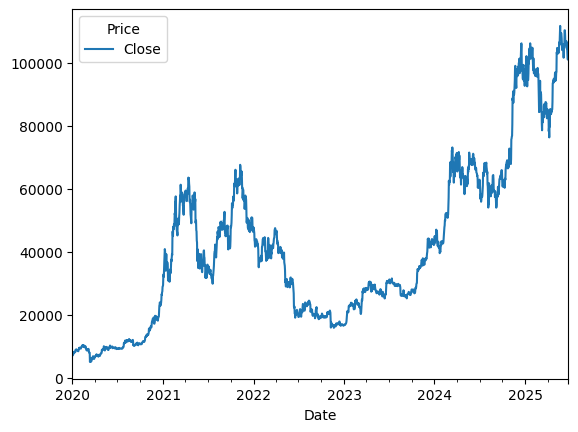

In [2]:
# DOWNLOAD DATA
# Download historical daily price data for Bitcoin (BTC-USD) from Yahoo Finance
data = yf.download('BTC-USD', start='2020-01-01', end='2025-06-25')
data.columns = data.columns.droplevel(1)

data = data[['Close']]
data.plot()

In [3]:
# NORMALIZE DATA
# This section scales the closing price data to a range between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [4]:
# CREATE SEQUENCES
# This function creates input-output pairs for time series prediction.
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Generate sequences
X, y = create_dataset(scaled_data)

# Resize X to be LSTM compatible
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [5]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_train.shape

(1359, 60, 1)

In [6]:
# BUILD LSTM MODEL
model = Sequential()

# Input layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Hidden layers
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2)) # A dropout lower than 0.3 is used to prevent excessive information loss, which could harm training

model.add(LSTM(units=20))
model.add(Dropout(0.2))

# Output layer (Dense). Predicts the next day's price
model.add(Dense(units=1))


In [7]:
# Compile and Summarize the Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 30)         │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,221 (94.61 KB)

 Trainable params: 24,221 (94.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# TRAIN AND PREDICT
model.fit(X_train, y_train, epochs=45, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0176 - mae: 0.0936 - val_loss: 0.0044 - val_mae: 0.0505
Epoch 2/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0029 - mae: 0.0378 - val_loss: 0.0090 - val_mae: 0.0775
Epoch 3/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0024 - mae: 0.0339 - val_loss: 0.0035 - val_mae: 0.0456
Epoch 4/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0027 - mae: 0.0362 - val_loss: 0.0036 - val_mae: 0.0460
Epoch 5/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0020 - mae: 0.0324 - val_loss: 0.0023 - val_mae: 0.0367
Epoch 6/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0020 - mae: 0.0312 - val_loss: 0.0085 - val_mae: 0.0774
Epoch 7/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0017 - mae: 0.0290 - val_loss: 0.0068 - val_mae: 0.0667
Epoch 8/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0015 - mae: 0.0273 - val_loss: 0.0026 - val_mae: 0.0398
Epoch 9/45
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0

In [10]:
# Predict using the trained model
y_pred = model.predict(X_test)
# Reshape the predictions to 2D (required by inverse_transform)
# Inverse transform to get the predictions back to original price scale
y_pred = y_pred.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [11]:
# Inverse transform the test target values to return them to their original price scale
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [12]:
y_test

array([ 37476.95703125,  35813.8125    ,  37432.33984375,  37289.62109375,
        37720.28125   ,  37796.79296875,  37479.12109375,  37254.16796875,
        37831.0859375 ,  37858.4921875 ,  37712.74609375,  38688.75      ,
        39476.33203125,  39978.390625  ,  41980.09765625,  44080.6484375 ,
        43746.4453125 ,  43292.6640625 ,  44166.6015625 ,  43725.984375  ,
        43779.69921875,  41243.83203125,  41450.22265625,  42890.7421875 ,
        43023.97265625,  41929.7578125 ,  42240.1171875 ,  41364.6640625 ,
        42623.5390625 ,  42270.52734375,  43652.25      ,  43869.15234375,
        43997.90234375,  43739.54296875,  43016.1171875 ,  43613.140625  ,
        42520.40234375,  43442.85546875,  42627.85546875,  42099.40234375,
        42156.90234375,  42265.1875    ,  44167.33203125,  44957.96875   ,
        42848.17578125,  44179.921875  ,  44162.69140625,  43989.1953125 ,
        43943.09765625,  46970.50390625,  46139.73046875,  46627.77734375,
        46368.5859375 ,  

In [13]:
# Display some predicted vs actual price values
print("Predictions vs Actual Prices")
for i in range(100):
    print(f"Prediction {i+1}: {y_pred[i]}, Actual Price: {y_test[i]}")

Predictions vs Actual Prices
Prediction 1: 35780.08203125, Actual Price: 37476.95703125
Prediction 2: 36068.3828125, Actual Price: 35813.8125
Prediction 3: 36073.3984375, Actual Price: 37432.33984375
Prediction 4: 36050.13671875, Actual Price: 37289.62109375
Prediction 5: 36080.1484375, Actual Price: 37720.28125
Prediction 6: 36236.37890625, Actual Price: 37796.79296875
Prediction 7: 36475.94140625, Actual Price: 37479.12109375
Prediction 8: 36653.12109375, Actual Price: 37254.16796875
Prediction 9: 36675.82421875, Actual Price: 37831.0859375
Prediction 10: 36671.37109375, Actual Price: 37858.4921875
Prediction 11: 36701.77734375, Actual Price: 37712.74609375
Prediction 12: 36744.86328125, Actual Price: 38688.75
Prediction 13: 36943.82421875, Actual Price: 39476.33203125
Prediction 14: 37381.03125, Actual Price: 39978.390625
Prediction 15: 37992.5, Actual Price: 41980.09765625
Prediction 16: 38919.53515625, Actual Price: 44080.6484375
Prediction 17: 40282.84765625, Actual Price: 43746.

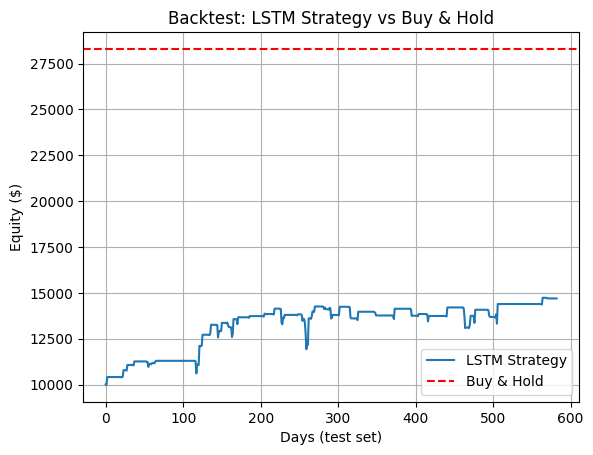

Final equity LSTM strategy: $14693.13
Buy & Hold equity: $28296.22
Return LSTM strategy: 46.93%
Return Buy & Hold: 182.96%


In [14]:
# BACKTESTING
# If tomorrow's predicted price > today's price, buy; if lower, sell
initial_cash = 10000
cash = initial_cash
asset = 0
equity_curve = []

commission = 0.002  # Transaction cost

for i in range(len(y_test)-1):
    price_today = y_test[i]
    price_pred = y_pred[i]

    # Buy signal
    if price_pred > price_today and cash > 0:
        asset = (cash * (1 - commission)) / price_today
        cash = 0

    # Sell signal
    elif price_pred < price_today and asset > 0:
        cash = (asset * price_today) * (1 - commission)
        asset = 0

    # Track daily total equity (cash + value of holdings)
    total_equity = cash + asset * price_today
    equity_curve.append(total_equity)

# Close remaining position at the end
if asset > 0:
    cash = asset * y_test[-1] * (1 - commission)
    asset = 0
equity_curve.append(cash)

# Buy & Hold baseline
price_initial = y_test[0]
price_final = y_test[-1]
buy_hold = initial_cash * (price_final / price_initial)

# PLOT RESULTS
plt.plot(equity_curve, label="LSTM Strategy")
plt.axhline(buy_hold, color='r', linestyle='--', label="Buy & Hold")
plt.title("Backtest: LSTM Strategy vs Buy & Hold")
plt.xlabel("Days (test set)")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()

# Final equity in USD
print(f"Final equity LSTM strategy: ${equity_curve[-1]:.2f}")
print(f"Buy & Hold equity: ${buy_hold:.2f}")

# Final returns in percentage
print(f"Return LSTM strategy: {((equity_curve[-1] - initial_cash) / initial_cash) * 100:.2f}%")
print(f"Return Buy & Hold: {((buy_hold - initial_cash) / initial_cash) * 100:.2f}%")


In [16]:
# Save Model and Scaler
# LSTM Model
model.save('lstm_model.h5')
# Scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# PART 2

# Class Implementation

In [21]:
class LSTMPricePredictor:

    def __init__(self, model_path, scaler_path, create_dataset, time_steps=60) -> None:
        self.model = load_model(model_path)
        self.scaler = joblib.load(scaler_path)
        self.create_dataset = create_dataset
        self.time_steps = time_steps
        # Si da error
        # tf.config.run_functions-eagerly(True)

    def predict_price(self, recent_prices):
        """
        Predict next price.
        recent_prices: list of array of the last 60(time steps) prices.
        """
        recent_prices = np.array(recent_prices).reshape(-1, 1)
        # Normalize Input
        scaled_input = self.scaler.transform(recent_prices)
        # Reshape for LSTM
        input_seq = np.reshape(scaled_input, (1, self.time_steps, 1))
        # Predict
        pred_scaled = self.model.predict(input_seq, verbose=0)
        # Inverse transform
        pred_price = self.scaler.inverse_transform(pred_scaled)

        return pred_price[0][0]

    def retrain(self, prices, epochs=10, batch_size=32):
      """
      Retrain the model with new prices
      prices: list of array of the last 60(time steps) prices.
      epochs: number of epochs to train.
      batch_size: batch size to train.
      """
      # Prepare the data
      prices = np.array(prices).reshape(-1, 1)
      scaled_prices = self.scaler.fit_transform(prices)
      X, y = self.create_dataset(scaled_prices)
      X = np.reshape(X, (X.shape[0], X.shape[1], 1))

      # Recompile the model before retraining
      self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

      # Retrain the model
      self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

      # Save the model and scaler updated
      self.model.save('lstm_model.h5')
      joblib.dump(self.scaler, 'scaler.pkl')
      return True

In [24]:
predictor = LSTMPricePredictor(model_path='lstm_model.h5', scaler_path='scaler.pkl', create_dataset=create_dataset, time_steps=60)

last_60_close_prices = yf.download('BTC-USD', start='2020-01-01', end='2025-06-25')
last_60_close_prices.columns = last_60_close_prices.columns.droplevel(1)
last_60_close_prices = last_60_close_prices['Close'][-60:]

all_historic_prices = yf.download('BTC-USD', start='2020-01-01', end='2025-06-25')
all_historic_prices.columns = all_historic_prices.columns.droplevel(1)
all_historic_prices = all_historic_prices['Close']

# Predict next price
next_price = predictor.predict_price(last_60_close_prices)
print(f"Next price: {next_price}")

#Retrain the model
predictor.retrain(all_historic_prices, epochs=10, batch_size=32)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Next price: 100981.109375
Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0020 - mae: 0.0282
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0018 - mae: 0.0282
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0014 - mae: 0.0266
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0016 - mae: 0.0275
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0015 - mae: 0.0267
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0016 - mae: 0.0278
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0016 - mae: 0.0257
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0013 - mae: 0.0244
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0013 - mae: 0.0253
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0014 - mae: 0.0257


True

# Conclusion